## Dataset Link → https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

About:

This dataset consists of **2,357 images** of malignant and benign skin diseases, derived from **The International Skin Imaging Collaboration (ISIC)**. All images have been categorized according to ISIC classification and organized into balanced subsets, except for melanoma and nevus, which have a slightly higher representation.

- **Classes**:
    - Actinic Keratosis
    - Basal Cell Carcinoma
    - Dermatofibroma
    - Melanoma
    - Nevus
    - Pigmented Benign Keratosis
    - Seborrheic Keratosis
    - Squamous Cell Carcinoma
    - Vascular Lesion


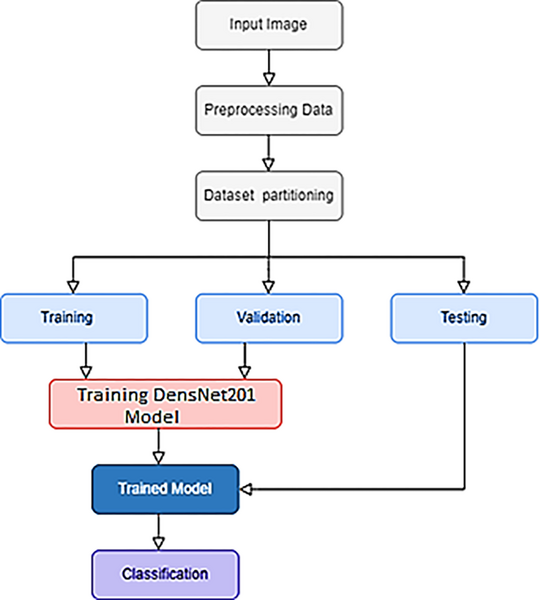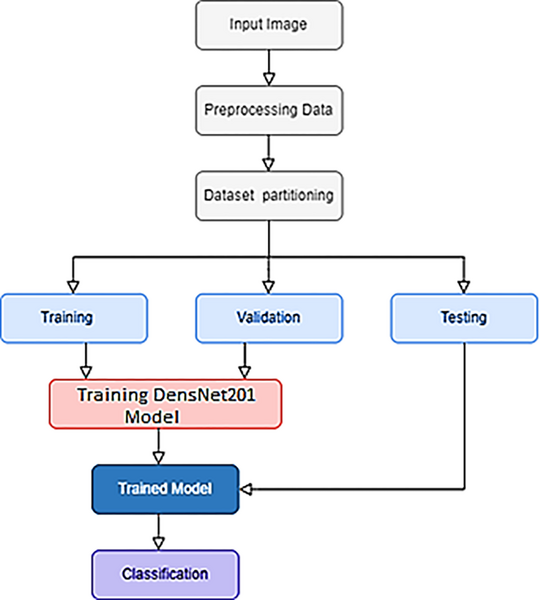

In [2]:
!pip install transformers
!pip install tensorflow==2.19.0


In [3]:
!pip install nvidia-pyindex nvidia-cuda-runtime-cu12 nvidia-cudnn-cu12


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 MB 23.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 25.2 MB/s eta 0:00:0000:0100:01
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8481 sha256=6ec976a49556d35a5149baa23a18d90f23700f8ed815bb7eb7273750600cea89
  Stored in directory: /home/codespace/.cache/pip/wheels/eb/2d/7f/d86cb060a9c51fb933aa4fe0d2f73ffe8df2bd0b58d3d2bba4
Successfully built nvidia-pyindex


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import concurrent.futures
import multiprocessing

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception as e:
    print(e)

# Get the number of CPU cores for parallel processing
max_workers = multiprocessing.cpu_count()
print(f"Number of CPU cores: {max_workers}")

# Function to create DataFrame from image directory
def create_dataframe(data_dir):
    data = [
        {"image_path": os.path.join(data_dir, dir_name, fname), "label": label}
        for label, dir_name in enumerate(os.listdir(data_dir))
        for fname in os.listdir(os.path.join(data_dir, dir_name))
    ]
    return pd.DataFrame(data)

# Function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((128, 128)))

# Function to plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot data distribution
def plot_data_distribution(class_counts, label_map):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(list(label_map.values()), class_counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Function to plot sample images
def plot_sample_images(df, label_map, num_samples=9):
    plt.figure(figsize=(15, 15))
    for i, class_label in enumerate(df['label'].unique()):
        if i >= num_samples:
            break
        sample = df[df['label'] == class_label].sample(1).iloc[0]
        img = sample['image']
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f"Class: {label_map[class_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to plot ROC curves
def plot_roc_curves(y_test, y_pred_proba, num_classes, label_map):
    plt.figure(figsize=(12, 10))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, 
                 label=f'ROC curve for {label_map[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # Return the average AUC
    return np.mean(list(roc_auc.values()))

# Function to create and train the model
def create_and_train_model(X_train, y_train, X_validate, y_validate, input_shape, num_classes, epochs=25):
    # Define the functional model
    input_tensor = Input(shape=input_shape)
    
    # Use DenseNet201 as base model
    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_tensor)
    
    # Add custom layers
    x = Flatten()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Set learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )
    
    # Fit the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs, 
        batch_size=32,
        validation_data=(X_validate, y_validate),
        callbacks=[learning_rate_reduction]
    )
    
    return model, history

# Main execution
def main():
    # Define paths
    train_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
    test_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
    max_images_per_class = 2000
    
    # Create combined dataframe
    df = pd.concat([create_dataframe(train_dir), create_dataframe(test_dir)], ignore_index=True)
    
    # Get list of directories and create label_map
    label_map = {i: label for i, label in enumerate(os.listdir(train_dir))}
    num_classes = len(label_map)
    print("Label mapping:", label_map)
    
    # Limit each class to max_images_per_class samples
    df = df.groupby("label").head(max_images_per_class).reset_index(drop=True)
    
    # Parallelize resizing process
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        df['image'] = list(executor.map(resize_image_array, df['image_path']))
    
    # Initialize ImageDataGenerator with transformations
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.5,
        height_shift_range=0.25,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Initialize augmented DataFrame
    augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])
    
    # Augment data to balance classes
    for class_label in df['label'].unique():
        # Get image arrays for the current class
        class_images = df[df['label'] == class_label]
        image_arrays = class_images['image'].values
        num_images_needed = max_images_per_class - len(image_arrays)
        
        # Add original images to augmented DataFrame
        augmented_df = pd.concat([augmented_df, class_images], ignore_index=True)
    
        if num_images_needed > 0:
            selected_images = np.random.choice(image_arrays, size=num_images_needed, replace=True)
            
            # Augment and add new images
            for img_array in selected_images:
                image_tensor = np.expand_dims(img_array, axis=0)
                augmented_images = datagen.flow(image_tensor, batch_size=1)
                
                for _ in range(1):  # Generate one augmented image at a time
                    augmented_img = augmented_images.next()[0].astype('uint8')
                    new_row = pd.DataFrame([{'image_path': None, 'label': class_label, 'image': augmented_img}])
                    augmented_df = pd.concat([augmented_df, new_row], ignore_index=True)
    
    # Limit the size of each class and shuffle
    df = augmented_df.groupby('label').head(max_images_per_class).sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Count the number of images in each class
    class_counts = df['label'].value_counts().sort_index()
    
    # Print the dataset summary
    print("Dataset Summary")
    print("-" * 60)
    print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
    print("-" * 60)
    for label, name in label_map.items():
        print(f"{label:<15} {name:<30} {class_counts[label]:<10}")
    print("-" * 60)
    print(f"{'Total':<45} {class_counts.sum():<10}")
    
    # Visualize data distribution
    plot_data_distribution(class_counts, label_map)
    
    # Plot sample images
    plot_sample_images(df, label_map)
    
    # Prepare data for training
    X = df.drop(columns=['label','image_path'], axis=1)
    y = df['label']
    
    # Split into train and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)
    
    # Convert images to numpy arrays
    X_train_val = np.asarray(X_train_val['image'].tolist())
    X_test = np.asarray(X_test['image'].tolist())
    
    # Normalize images
    X_train_val_mean, X_train_val_std = X_train_val.mean(), X_train_val.std()
    X_test_mean, X_test_std = X_test.mean(), X_test.std()
    
    X_train_val = (X_train_val - X_train_val_mean) / X_train_val_std
    X_test = (X_test - X_test_mean) / X_test_std
    
    # One-hot encode the labels
    y_train_val = to_categorical(y_train_val, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)
    
    # Split data into training and validation sets
    X_train, X_validate, y_train, y_validate = train_test_split(
        X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=42
    )
    
    # Reshape images
    input_shape = (128, 128, 3)
    X_train = X_train.reshape(-1, 128, 128, 3)
    X_validate = X_validate.reshape(-1, 128, 128, 3)
    X_test = X_test.reshape(-1, 128, 128, 3)
    
    # Count the number of images per class in each split
    train_counts = np.sum(y_train, axis=0)
    val_counts = np.sum(y_validate, axis=0)
    test_counts = np.sum(y_test, axis=0)
    
    # Print dataset split summary
    print("\nDataset Split Summary")
    print("-" * 90)
    print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
    print("-" * 90)
    for label, name in label_map.items():
        train_num = int(train_counts[label])
        val_num = int(val_counts[label])
        test_num = int(test_counts[label])
        total_num = train_num + val_num + test_num
        print(f"{label:<15} {name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
    print("-" * 90)
    total_images = len(y_train) + len(y_validate) + len(y_test)
    print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {total_images:<10}")
    
    # Create and train the model
    model, history = create_and_train_model(
        X_train, y_train, X_validate, y_validate, input_shape, num_classes, epochs=25
    )
    
    # Visualize training history
    plot_training_history(history)
    
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, list(label_map.values()))
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(label_map.values())))
    
    # Plot ROC curves
    avg_auc = plot_roc_curves(y_test, y_pred_proba, num_classes, label_map)
    print(f"Average AUC: {avg_auc:.4f}")
    
    # Save the model
    model.save('/kaggle/working/model.h5')
    print("Model saved successfully!")
    
    # Test with a single image
    test_image_path = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/ISIC_0000015.jpg'
    test_img = resize_image_array(test_image_path)
    
    # Display the test image
    plt.figure(figsize=(6, 6))
    plt.imshow(test_img)
    plt.title("Test Image")
    plt.axis('off')
    plt.show()
    
    # Preprocess for prediction
    test_img = np.expand_dims(test_img, axis=0)
    test_img = (test_img - X_test_mean) / X_test_std
    
    # Predict
    prediction = model.predict(test_img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = label_map[predicted_class]
    
    # Show prediction
    print(f"Predicted Class: {predicted_label}")
    print(f"Confidence: {prediction[0][predicted_class]:.4f}")
    
    # Show prediction distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(label_map.values()), y=prediction[0])
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.title('Prediction Probability Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()